In [ ]:
!pip install geopandas shapely pyproj folium contextily

In [ ]:
!pip install pytrends

In [50]:
# Imports
# Geometry
from shapely.geometry import Point
from shapely.geometry import Polygon

# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import folium
from IPython.display import display
import contextily as ctx

# Projections
import pyproj
from pyproj import CRS, Transformer

# Data handling
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
from google.colab import drive
from pytrends.request import TrendReq

In [51]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# Read Data
archivo_xlsx = '/content/drive/MyDrive/Diversa/PUCE/base suicidios.xlsx'
df1 = pd.read_excel(archivo_xlsx)

# Shape file
ecu_shp = gpd.read_file("/content/drive/MyDrive/Diversa/PUCE/shp_Ecuador/nxprovincias.shp")
if ecu_shp.crs is None:
    ecu_shp.crs = 'epsg:32717'
ecu_shp = ecu_shp.to_crs('epsg:4326')
ecu_shp = ecu_shp[['DPA_PROVIN', 'geometry']]

In [53]:
df1.head()

,provincia,fuente1,sexo,año_f,mes_fall,mes_fall1,edad,cod_eda,cau,cau1d,cau2d,cau3d,año,edad2,n,cie10_des,GBD,FECHA
0,02 Bolívar,EDG_2011,Mujer,2011,7,7,26,4 Años (1 a 115 años de edad),X609,X,X6,X60,2011,26,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2011-07-28
1,02 Bolívar,EDG_2011,Hombre,2011,8,8,23,4 Años (1 a 115 años de edad),X609,X,X6,X60,2011,23,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2011-08-28
2,18 Tungurahua,EDG_2012,Mujer,2012,6,6,14,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,14,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-06-28
3,16 Pastaza,EDG_2012,Hombre,2012,2,2,21,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,21,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-02-28
4,16 Pastaza,EDG_2012,Hombre,2012,2,2,34,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,34,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-02-28


In [54]:
## Subset, clean and rename df

# Rename
column_names_in_english = {
    'provincia': 'province',
    'sexo': 'gender',
    'edad': 'age',
    'cie10_des': 'description',
    'FECHA': 'date'
}
df1.rename(columns=column_names_in_english, inplace=True)

# Clean Description
df1['description'] = df1['description'].str.extract(' (.*)')
description_translation = {
    'Envenenamiento autoinfligido intencionalmente por': 'Self-poisoning',
    'Lesión autoinfligida intencionalmente por ahorcamiento': 'Self-hanging',
    'Lesión autoinfligida intencionalmente por objeto cortante': 'Self-harm with sharp object',
    'Lesión autoinfligida intencionalmente al saltar desde un lugar elevado': 'Self-harm by jumping from high place'
}
df1['description'] = df1['description'].replace(description_translation)

# Make age range
df1['age'] = df1['age'].replace(999, 99)
age_bins = [0, 4, 9, 14, 19, 24, 34, 44, 54, 64, 74, 84, 100]
age_labels = [
    "Infants and toddlers (0-4)",
    "Children (5-9)",
    "Pre-teens (10-14)",
    "Teens (15-19)",
    "Young adults (20-24)",
    "Adults (25-34)",
    "Middle-aged adults (35-44)",
    "Older adults (45-54)",
    "Seniors (55-64)",
    "Retirement age (65-74)",
    "Elderly (75-84)",
    "Very elderly (+85)"
]
df1['age_range'] = pd.cut(df1['age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

# Clean gender
gender_translation = {
    'Hombre': 'M',
    'Mujer': 'F'
}
df1['gender'] = df1['gender'].replace(gender_translation)

# Clean province and get the geometry
df1['province_code'] = df1['province'].str.extract('(\d+)')
df1['province'] = df1['province'].str.extract('([^\d]+)')
df1 = df1.merge(ecu_shp, left_on='province_code', right_on='DPA_PROVIN', how='left')
columns_to_keep = ['date','province', 'province_code', 'geometry','gender','age','age_range','description']

df1 = df1[columns_to_keep]

In [55]:
df1.dtypes

date             datetime64[ns]
province                 object
province_code            object
geometry               geometry
gender                   object
age                       int64
age_range              category
description              object
dtype: object

In [43]:
df1.head()

,date,province,province_code,geometry,gender,age,age_range,description
0,2011-07-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",F,26,Adults (25-34),Self-poisoning
1,2011-08-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",M,23,Young adults (20-24),Self-poisoning
2,2012-06-28,Tungurahua,18,"POLYGON ((-78.40470 -0.98958, -78.40439 -0.991...",F,14,Pre-teens (10-14),Self-poisoning
3,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,21,Young adults (20-24),Self-poisoning
4,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,34,Adults (25-34),Self-poisoning


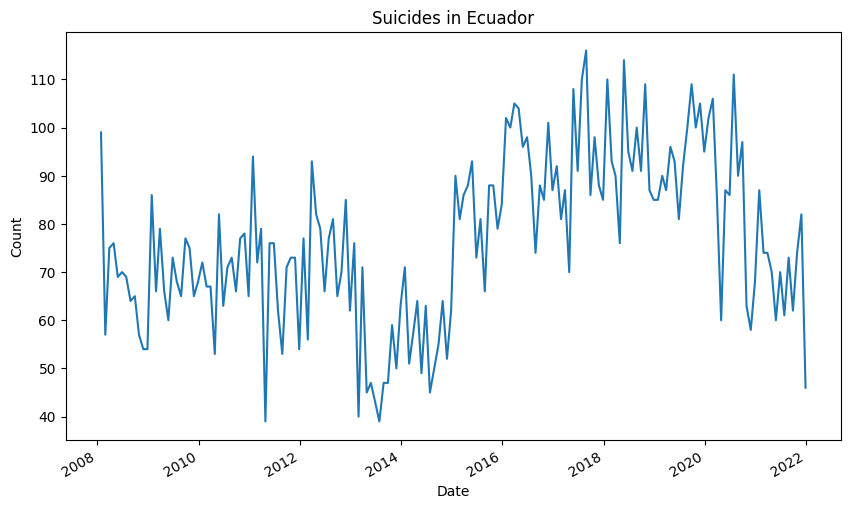

In [56]:
df1 = df1.copy()
df1['date'] = pd.to_datetime(df1['date'])
df_grouped = df1[df1['date'].dt.year >= 2008].groupby('date').size()
df_grouped.plot(kind='line', figsize=(10, 6))
plt.title('Suicides in Ecuador')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


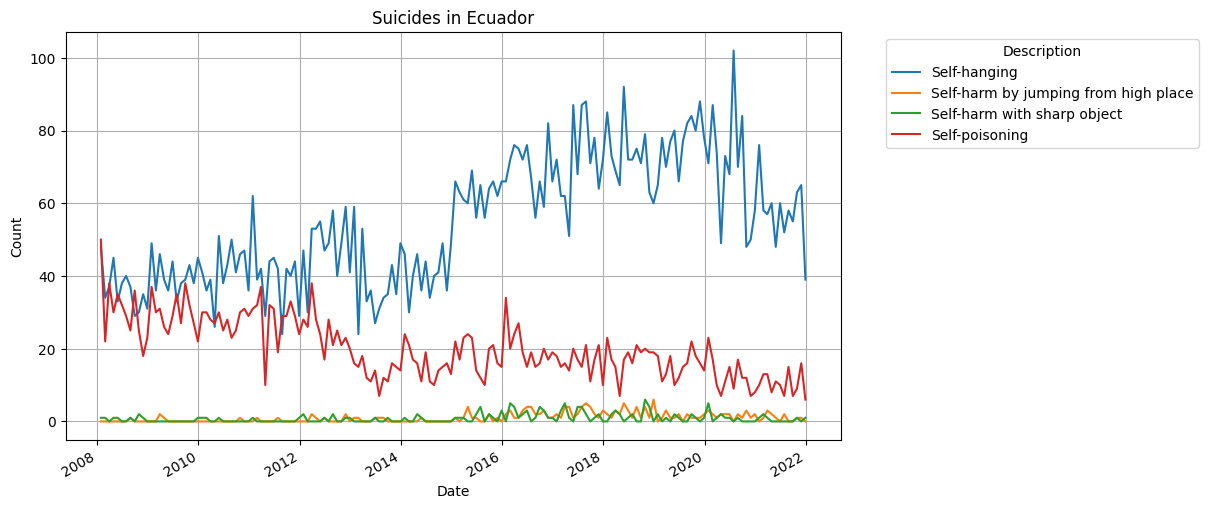

In [57]:
# Group the data by date and description
df_grouped = df1[df1['date'].dt.year >= 2008].groupby(['date', 'description']).size().unstack(fill_value=0)

# Plot a line for each description
df_grouped.plot(kind='line', figsize=(10, 6))

plt.title('Suicides in Ecuador')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

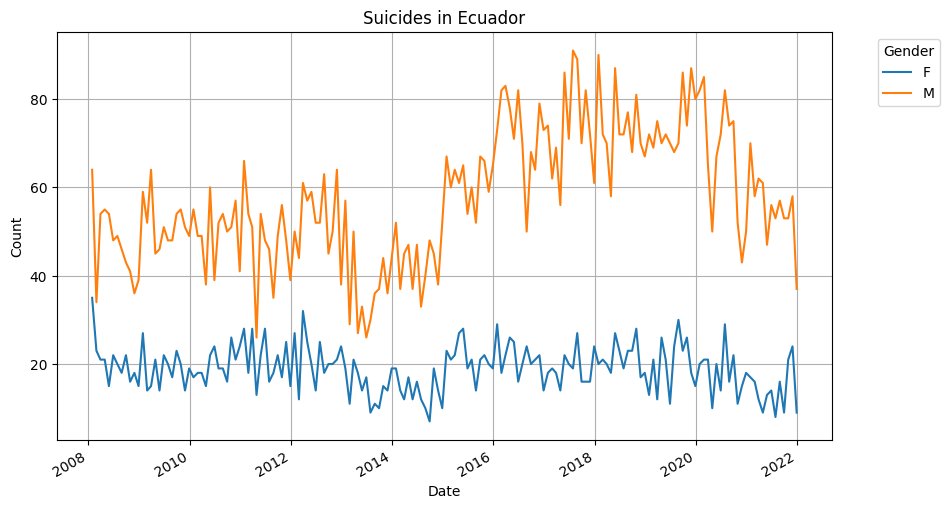

In [46]:
# Group the data by date and description
df_grouped = df1[df1['date'].dt.year >= 2008].groupby(['date', 'gender']).size().unstack(fill_value=0)

# Plot a line for each description
df_grouped.plot(kind='line', figsize=(10, 6))

plt.title('Suicides in Ecuador')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

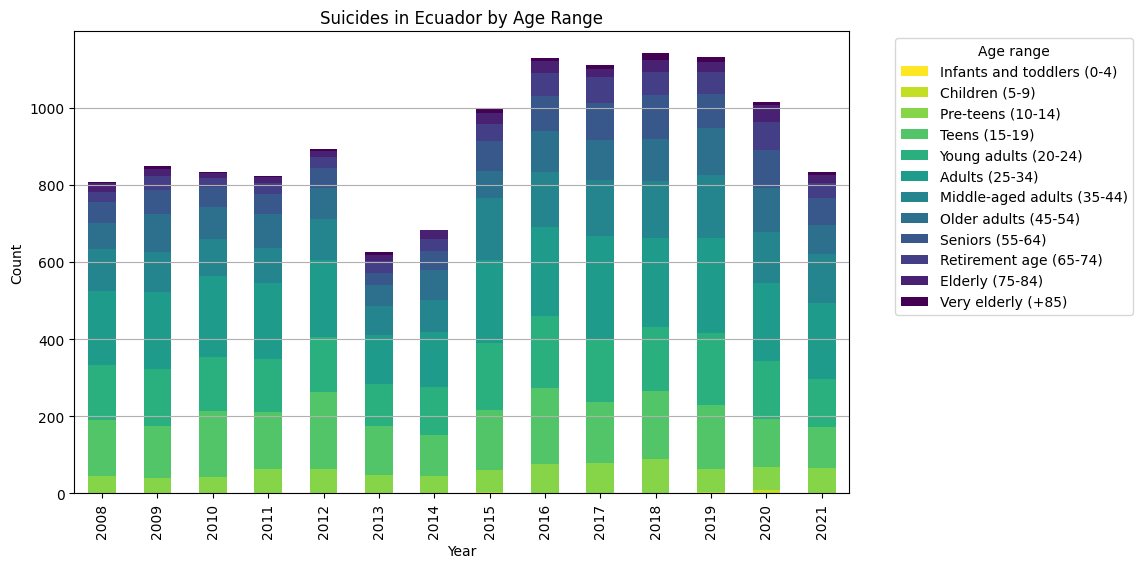

In [47]:
# Group the data by year and age_range to get the count for each combination
df_grouped = df1[df1['date'].dt.year >= 2008].groupby([df1['date'].dt.year, 'age_range']).size().unstack(fill_value=0)

# Plot a stacked bar plot with years on the X-axis and counts on the Y-axis
df_grouped.plot(kind='bar', stacked=True, figsize=(10,6), cmap='viridis_r')

plt.title('Suicides in Ecuador by Age Range')
plt.xlabel('Year')
plt.ylabel('Count')  # Cambia el título del eje Y a "Count"
plt.legend(title='Age range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()


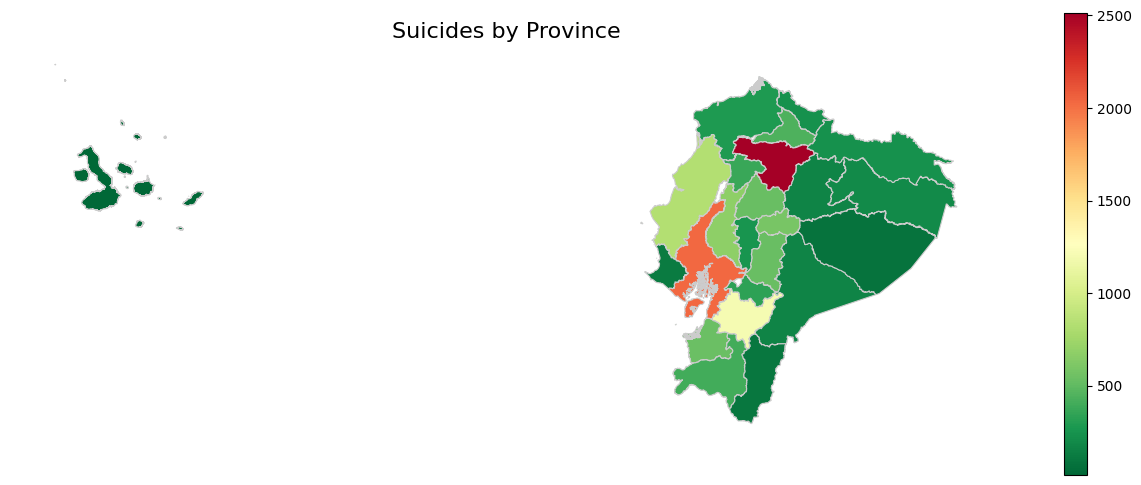

In [48]:
# Group by province and calculate the total number of cases
province_counts = df1.groupby(['province', 'geometry']).size().reset_index(name='count')

# Create a GeoDataFrame with the province geometries and case counts
province_count = gpd.GeoDataFrame(province_counts, geometry='geometry')

# Create a larger figure
fig, ax = plt.subplots(1, 1, figsize=(16, 10))  # Adjust the figure size as needed

# Plot the map with a smaller color legend
province_count.plot(
    column='count',
    cmap='RdYlGn_r',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'shrink': 0.6}  # Adjust the 'shrink' parameter to control legend size
)

# Set plot title and axis labels
ax.set_title('Suicides by Province', fontsize=16)
ax.set_axis_off()
plt.show()



In [49]:
province_count

,province,geometry,count
0,Azuay,"POLYGON ((-78.56954 -2.55865, -78.56920 -2.558...",1202
1,Bolívar,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",256
2,Carchi,"POLYGON ((-78.49647 1.19776, -78.49573 1.19763...",237
3,Cañar,"POLYGON ((-78.56954 -2.55865, -78.57007 -2.559...",336
4,Chimborazo,"POLYGON ((-78.35800 -1.52162, -78.35800 -1.521...",534
5,Cotopaxi,"POLYGON ((-78.42185 -0.71691, -78.42185 -0.716...",534
6,El Oro,"MULTIPOLYGON (((-80.20645 -3.43884, -80.20748 ...",540
7,Esmeraldas,"MULTIPOLYGON (((-79.90438 0.27876, -79.90431 0...",285
8,Galápagos,"MULTIPOLYGON (((-89.66637 -1.34547, -89.66625 ...",19
9,Guayas,"MULTIPOLYGON (((-80.16401 -3.01416, -80.16472 ...",2026


In [ ]:
# Palabras clave que deseas consultar
keywords = ['suicidio', 'suicidarme', 'matarme']
pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2008-01-01'
end_date = '2022-12-31'
pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
data = pytrends.interest_over_time()
df2 = pd.DataFrame(data)
df2.head()

,suicidio,suicidarme,matarme,isPartial
date,,,,
2008-01-01,69,23,16,False
2008-02-01,45,0,0,False
2008-03-01,32,0,0,False
2008-04-01,63,0,39,False
2008-05-01,70,0,0,False


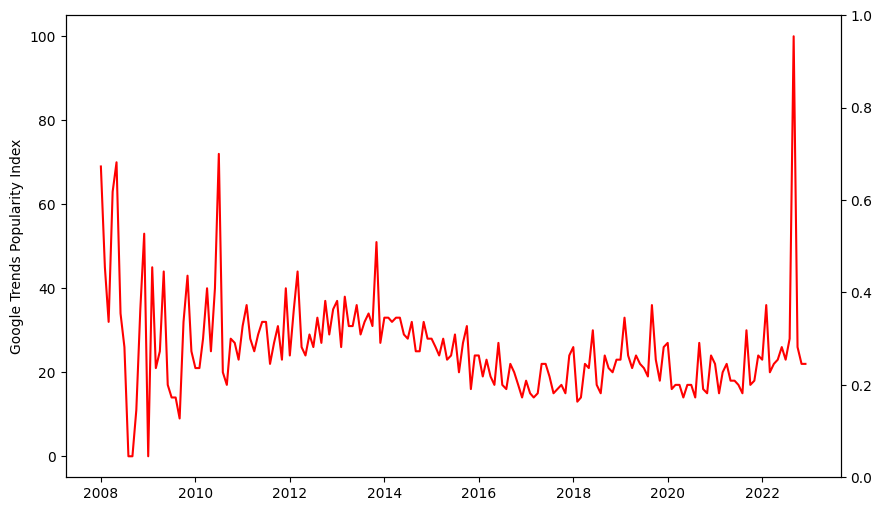

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(df2.index, df2['suicidio'], color='Red', label='Key word: Suicidio')
ax1.set_ylabel('Google Trends Popularity Index')
plt.show()

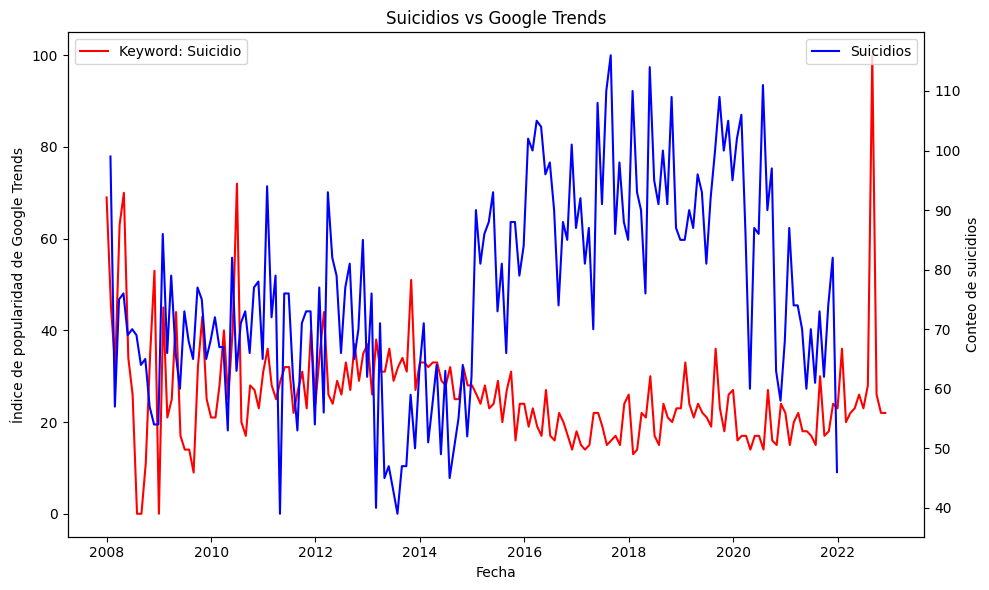

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(df2.index, df2['suicidio'], color='Red', label='Keyword: Suicidio')
ax1.set_ylabel('Índice de popularidad de Google Trends')
ax2.plot(df_agrupado.index, df_agrupado, color='Blue', label='Suicidios')
ax2.set_ylabel('Conteo de suicidios')
ax1.set_xlabel('Fecha')
ax1.set_title('Suicidios vs Google Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()